# Chapter 3: Multimodal RAG

**From Zero to Hero: Build a Retrieval-Augmented Generation from Scratch**

---

*Links:*
- *Read [Chapter 3 blog](https://medium.com/@marcharaoui/chapter-3-multimodal-rag-e3fdd9b3e450)*
- *Code repository on [GitHub](https://github.com/marcharaoui/RAG-from-scratch/tree/main/chapter3)*

*Author:*

Marc Haraoui

[LinkedIn](https://www.linkedin.com/in/marc-haraoui/) | [GitHub](https://github.com/marcharaoui) | [X](https://x.com/marcharaoui) | [Hugging Face](https://huggingface.co/MarcHaraoui) | [Medium](https://medium.com/@marcharaoui)

---

Welcome to the Chapter 3 Notebook! 🎉

This notebook serves as a modular and fully reusable hands-on guide for building an advanced MM RAG pipeline, aligning with the concepts discussed in Chapter 3, as shown here:

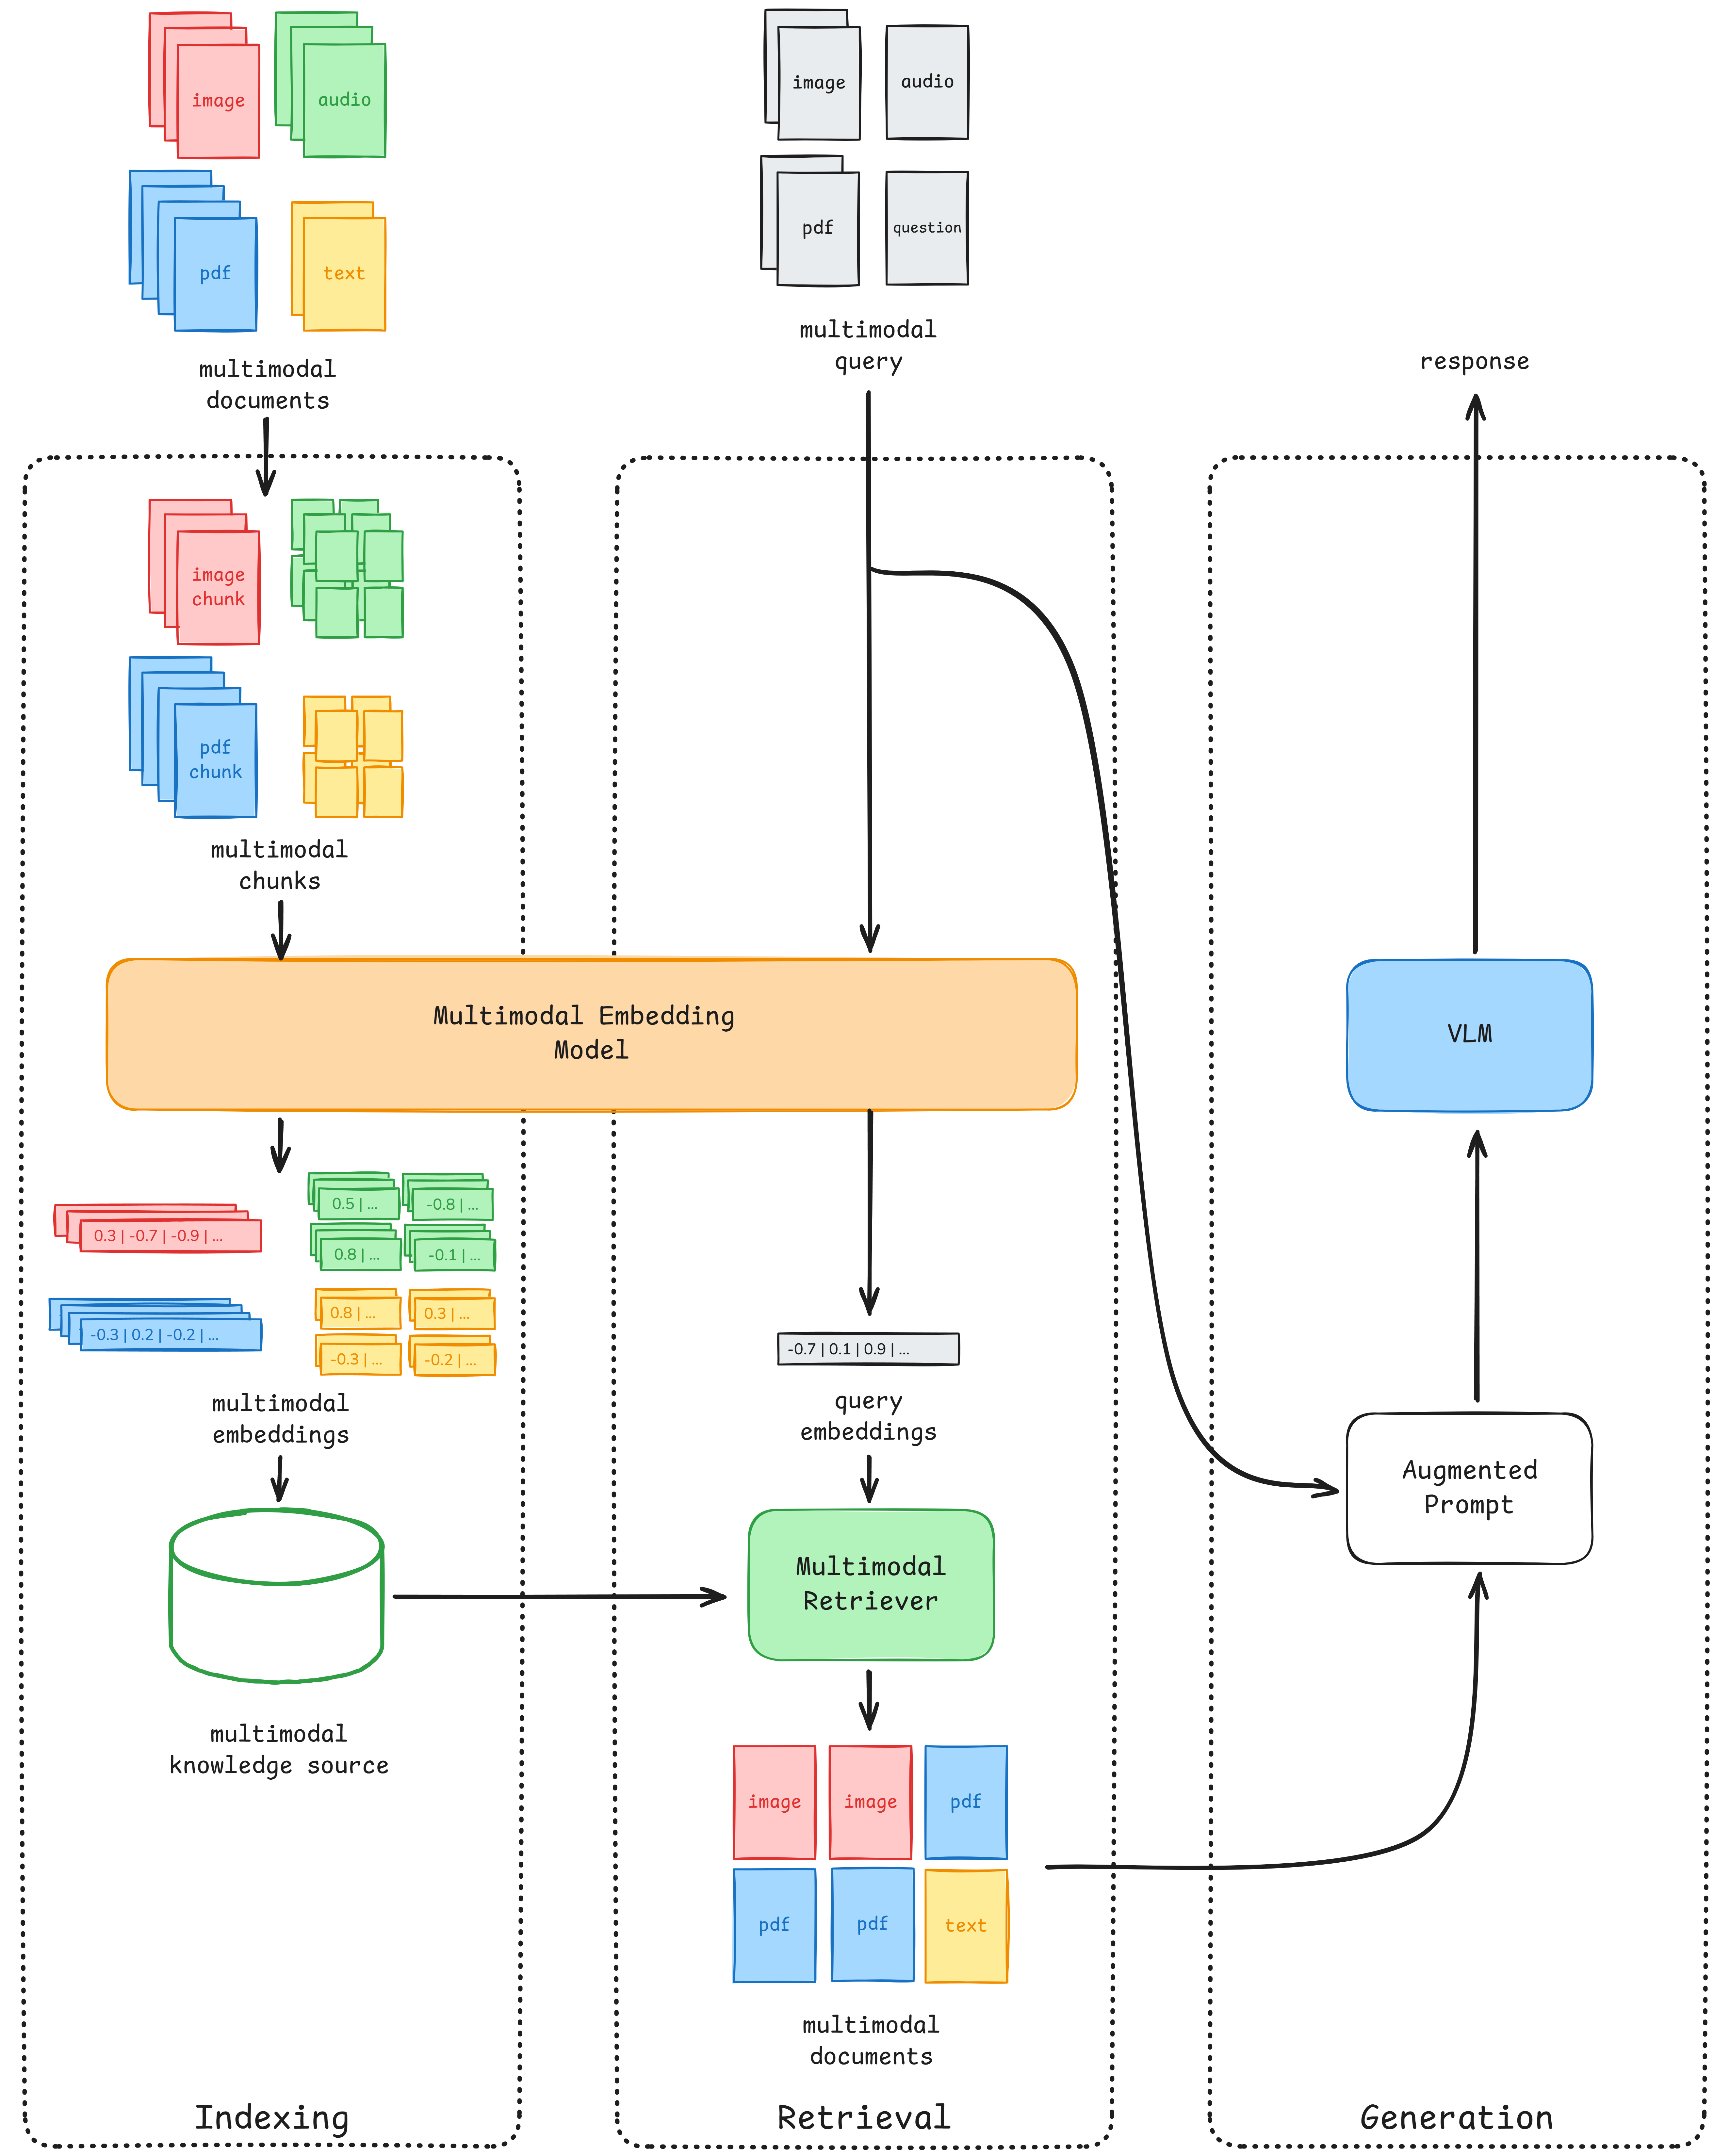

The goal of this notebook is for you to design and explore a fully manageable a MM RAG pipeline specific to your use case. More specifically, this code demonstrates a practical use case of MM RAG from creating a knowledge base to generating responses using multimodal data.

 We will be using a framework called LangChain for text chunking techniques. We embed the documents locally, and you can also store them locally, to retrieve them during another time, or use a vectorstore such as FAISS, Chroma, Pinecone, or Milvus.

Let’s get started! Happy coding🚀

*P.S. this notebook could be updated and improved over time*

## Setup

Start by installing and importing the required packages.


In [1]:
!pip install langchain-text-splitters langchain-huggingface scikit-learn pymupdf num2words requests
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-t153jwhx
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-t153jwhx
  Resolved https://github.com/huggingface/transformers.git to commit 794fde7b1c3d041519fc28ea3e1461b0cfcad4e7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Import the libraries

In [41]:
import os
import json
import numpy as np
from datetime import date
from PIL import Image
import pymupdf
from langchain_text_splitters import RecursiveCharacterTextSplitter
from transformers import AutoProcessor, AutoModel, AutoModelForVision2Seq
from sklearn.metrics.pairwise import cosine_similarity
import langchain, transformers, sklearn, torch
import requests
from transformers.image_utils import load_image
from matplotlib import pyplot as plt

Versions used for this notebook:

```
Python 3.11.11
Numpy version 2.0.2
Transformers version 4.52.0.dev0
LangChain version 0.3.22
Scikit-learn version 1.6.1
PyMuPDF version 1.25.5
```

Check yours:


In [ ]:
!python --version
print(f"Numpy version {np.__version__}")
print(f"Transformers version {transformers.__version__}")
print(f"LangChain version {langchain.__version__}")
print(f"Scikit-learn version {sklearn.__version__}")
print(f"PyMuPDF version {pymupdf.__version__}")

Python 3.11.11
Numpy version 2.0.2
Transformers version 4.52.0.dev0
LangChain version 0.3.22
Scikit-learn version 1.6.1
PyMuPDF version 1.25.5


## Creating the Multimodal RAG system

For this demo, we will be using SigLIP 2, a multimodal encoder from Google, that transforms multimodal data to 768 dimensionally dense vectors. We will also be using SmolVLM, a small (500M) vision-language model (VLM) by Hugging Face, for the generator model.

You can pick any embedding model or VLM with little to no code modification. The code uses Hugging Face open source models, so feel free to explore!

The following class lets you create a new knowledge base (with metadata), save and load it (with embeddings stored separately as a NumPy file), as well as add additional documents to an existing knowledge base, retrieve top-k relevant documents, and generate a final response.

*Heads up: you would need a GPU to make this run fast. We use small models in case you do not have access to a GPU, but note that it would take 20-30min to generate a response!*





In [3]:
class MultimodalRAG:
    """
    Multimodal RAG pipeline that supports text, images and PDFs.
    It enables advanced semantic retrieval and multimodal generative responses.
    """

    def __init__(self,
                  embedding_model: str = "google/siglip2-base-patch16-naflex",
                  generator_model: str = "HuggingFaceTB/SmolVLM-500M-Instruct"):
        """ Initialize the RAG pipeline."""
        # Setup device
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Load multimodal embedding model
        self.embedding_processor = AutoProcessor.from_pretrained(embedding_model)
        self.embedding_model = AutoModel.from_pretrained(embedding_model).to(self.device)

        # Load the vision-language model
        self.generator_processor = AutoProcessor.from_pretrained(generator_model)
        self.generator_model = AutoModelForVision2Seq.from_pretrained(
            generator_model,
            torch_dtype=torch.bfloat16,
        ).to(self.device)

        # Initialize knowledge base
        self.knowledge_base = []
        self.embeddings = np.array([])


    def embed_multimodal(self, data, modality: str) -> np.ndarray:
        """ Generate embeddings based on modality."""
        with torch.no_grad():
            if modality == "text":
                inputs    = self.embedding_processor(text=[data], return_tensors="pt").to(self.embedding_model.device)
                embedding = self.embedding_model.get_text_features(**inputs)
            elif modality == "image":
                inputs    = self.embedding_processor(images=[data], return_tensors="pt").to(self.embedding_model.device)
                embedding = self.embedding_model.get_image_features(**inputs)
            else:
                raise ValueError(f"Unsupported modality: {modality}.")
        return embedding.cpu().numpy().flatten()


    def chunk_text(self, text, chunk_size=500, overlap=50):
        """ Recursively split text into chunks."""
        splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
        return splitter.split_text(text)


    def process_pdf(self, pdf_path):
        """ Convert PDF into page-wise image chunks."""
        doc = pymupdf.open(pdf_path)
        pdf_chunks = []
        for page_num, page in enumerate(doc, start=1):
            pix = page.get_pixmap()
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            pdf_chunks.append({
                "type": "image",
                "content": img,
                "metadata": {"page": page_num, "source": pdf_path}
            })
        return pdf_chunks


    def save_knowledge_base(self, dir_path="knowledge_base_folder"):
        """ Save knowledge base and embeddings."""
        os.makedirs(dir_path, exist_ok=True)
        kb_path = os.path.join(dir_path, f"kb_{date.today()}.json")
        embeddings_path = os.path.join(dir_path, f"embeddings_{date.today()}.npy")

        kb_serializable = []
        for item in self.knowledge_base:
            data = {
                "type": item["type"],
                "id": item["id"],
                "chunk_id": item["chunk_id"],
            }
            if item["type"] == "text":
                data["content"] = item["content"]
            elif item["type"] == "image":
                image_path = os.path.join(dir_path, f"{item['id']}_{item['chunk_id']}.png")
                item["content"].save(image_path)
                data["content"] = image_path
            kb_serializable.append(data)

        with open(kb_path, "w") as f:
            json.dump(kb_serializable, f, indent=2)
        np.save(embeddings_path, self.embeddings)


    def load_knowledge_base(self, kb_path, embeddings_path):
        """ Load knowledge base and embeddings."""
        with open(kb_path, "r") as f:
            kb_data = json.load(f)

        self.knowledge_base = []
        for item in kb_data:
            if item["type"] == "image":
                item["content"] = Image.open(item["content"])
            self.knowledge_base.append(item)

        self.embeddings = np.load(embeddings_path)


    def add_documents(self, docs):
        """ Add documents to knowledge base and update embeddings."""
        new_embeddings = []
        for doc in docs:
            doc_id = doc["id"]
            modality = doc["type"]

            if modality == "text":
                text_chunks = self.chunk_text(doc["content"])
                for idx, chunk in enumerate(text_chunks):
                    embedding = self.embed_multimodal(chunk, "text")
                    self.knowledge_base.append({
                        "type": "text", "id": doc_id, "chunk_id": idx, "content": chunk
                    })
                    new_embeddings.append(embedding)

            elif modality == "image":
                embedding = self.embed_multimodal(doc["content"], "image")
                self.knowledge_base.append({
                    "type": "image", "id": doc_id, "chunk_id": 0, "content": doc["content"]
                })
                new_embeddings.append(embedding)

            elif modality == "pdf":
                chunks = self.process_pdf(doc["content"])
                for chunk in chunks:
                    embedding = self.embed_multimodal(chunk["content"], "image")
                    self.knowledge_base.append({
                        "type": "image",
                        "id": doc_id,
                        "chunk_id": chunk["metadata"]["page"],
                        "content": chunk["content"],
                        "source": chunk["metadata"]["source"]
                    })
                    new_embeddings.append(embedding)
            else:
                raise ValueError("Unsupported document type: text, image, pdf")

        self.embeddings = np.vstack([self.embeddings, new_embeddings]) if self.embeddings.size else np.array(new_embeddings)


    def retrieve_context(self, query, modality, top_k=3):
        """ Perform semantic search and retrieve context."""
        if modality == "text":
            query_emb = self.embed_multimodal(query["text"], "text")
        elif modality == "image":
            query_emb = self.embed_multimodal(query["image"], "image")
        elif modality == "image-text":
            text_emb = self.embed_multimodal(query["text"], "text")
            img_emb = self.embed_multimodal(query["image"], "image")
            query_emb = (text_emb + img_emb) / 2
        else:
            raise ValueError("Unsupported query modality")

        similarities = cosine_similarity(query_emb.reshape(1, -1), self.embeddings)[0]
        top_idxs = similarities.argsort()[::-1][:top_k]

        return [self.knowledge_base[i] for i in top_idxs]


    def generate_response(self, query, retrieved_context, instructions="Answer using the provided multimodal context."):
        """ Generate response using retrieved context and a VLM."""
        context_text = ""
        images       = []

        for chunk in retrieved_context:
            if chunk["type"] == "text":
                context_text += f"Text: {chunk['content']}\n"
            elif chunk["type"] == "image":
                # context_text += "<image>\n"
                images.append(chunk["content"])

        # Construct the augmented prompt with placeholders
        augmented_prompt = f"{instructions}\n\nContext:\n{context_text}\n\nQuery: {query['text']}\n\nAnswer:"

        # Add query image if exists
        if 'image' in query:
            if type(query['image']) == list:
                images.extend(query['image'])
            else:
                images.append(query['image'])

        if images:
            messages = [{
                "role": "user",
                "content": [{"type": "image"} for _ in images] + [{"type": "text", "text": augmented_prompt}]
            }]

            # Prepare inputs
            prompt = self.generator_processor.apply_chat_template(messages, add_generation_prompt=True)
            inputs = self.generator_processor(text=prompt, images=images, return_tensors="pt").to(self.device)

        else:
            messages = [{
                  "role": "user",
                  "content": [{"type": "text", "text": augmented_prompt}]
              }]

            # Prepare inputs
            prompt = self.generator_processor.apply_chat_template(messages, add_generation_prompt=True)
            inputs = self.generator_processor(text=prompt, return_tensors="pt").to(self.device)


        # Generate outputs
        generated_ids = self.generator_model.generate(**inputs, max_new_tokens=500)
        response_text = self.generator_processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )[0]

        return response_text

## How to use

Indexing is an offline task, meaning it is done ahead of time. This allows you to quickly look up relevant information at query-time.

When the user sends a query, the goal is to retrieve relevant documents, combine them with the query and specific instructions, and have the VLM generate a tailored answer in natural language.


### Data Preparation
For this demo, we'll add one text, one image, and one PDF document.

In [26]:
# Text documents ==================================
text_doc_1 = {
    "id": "doc_1",
    "type": "text",
    "content": "The origins of pizza date back to ancient times, with flatbreads being consumed by civilizations such as the Greeks, Romans, and Egyptians. However, modern pizza as we know it today originated in Naples, Italy, during the 18th and 19th centuries. It was initially a simple flatbread topped with basic ingredients like garlic and olive oil, primarily eaten by the working class."
}

text_doc_2 = {
    "id": "doc_2",
    "type": "text",
    "content": "The Statue of Liberty, officially named Liberty Enlightening the World, is one of the most iconic symbols of freedom and democracy in the United States. Standing on Liberty Island in New York Harbor, it was a gift from France to the United States, commemorating their friendship and shared ideals of liberty. Dedicated on October 28, 1886, the statue also celebrated the abolition of slavery following the U.S. Civil War."
}

# Image documents ==================================
img_url_1 = "https://images.unsplash.com/photo-1547721064-da6cfb341d50" # image of a giraffe from unsplash
img_url_2 = "https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg" # image of the statue of liberty

# Load image using Hugging Face's utility
img_1 = load_image(img_url_1)
img_2 = load_image(img_url_2)

image_doc_1 = {
    "id": "doc_3",
    "type": "image",
    "content": img_1
}

image_doc_2 = {
    "id": "doc_4",
    "type": "image",
    "content": img_2
}

# PDF document ==================================
pdf_url = "https://arxiv.org/pdf/1706.03762.pdf" # attention is all you need paper downloaded
pdf_path = "attention_is_all_you_need.pdf"
pdf_response = requests.get(pdf_url)
with open(pdf_path, "wb") as f:
    f.write(pdf_response.content)

pdf_doc = {
    "id": "doc_5",
    "type": "pdf",
    "content": pdf_path
}

documents = [text_doc_1, text_doc_2, image_doc_1, image_doc_2, pdf_doc]

### Setup the MM RAG Pipeline

In [27]:
# Initialize the MultimodalRAG object (loads SigLIP 2 and SmolVLM models by default)
rag = MultimodalRAG()

In [28]:
# Add list of documents into MultimodalRAG
rag.add_documents(documents)

Save and load your multimodal knowledge base

In [15]:
# Save the knowledge base
rag.save_knowledge_base("my_multimodal_kb")

In [16]:
# Load the knowledge base
rag.load_knowledge_base(
    kb_path="my_multimodal_kb/kb_{}.json".format(date.today()),
    embeddings_path="my_multimodal_kb/embeddings_{}.npy".format(date.today())
)

### Test the retrieval with multimodal queries


In [29]:
def show_retrieved_docs(retrieved_chunks):
    for idx, chunk in enumerate(retrieved_chunks):
        if chunk["type"] == "image":
            plt.figure(figsize=(6, 6))
            plt.imshow(chunk["content"])
            plt.axis('off')
            title = f'Doc Id: {chunk["id"]}, Doc Chunk: {chunk["chunk_id"]}'
            plt.title(f'Retrieved Image - {title}')
            plt.show()

        elif chunk["type"] == "text":
            print(f"Retrieved Text Chunk {idx+1}:")
            print(chunk["content"])
            print("\n" + "-"*50 + "\n")

Perform semantic search using a textual query

In [36]:
query_text = {
    "text": "Who created pizza?"
    }
retrieved_chunks = rag.retrieve_context(query_text, modality="text", top_k=1)
show_retrieved_docs(retrieved_chunks)

Retrieved Text Chunk 1:
The origins of pizza date back to ancient times, with flatbreads being consumed by civilizations such as the Greeks, Romans, and Egyptians. However, modern pizza as we know it today originated in Naples, Italy, during the 18th and 19th centuries. It was initially a simple flatbread topped with basic ingredients like garlic and olive oil, primarily eaten by the working class.

--------------------------------------------------



Retrieved Text Chunk 1:
The Statue of Liberty, officially named Liberty Enlightening the World, is one of the most iconic symbols of freedom and democracy in the United States. Standing on Liberty Island in New York Harbor, it was a gift from France to the United States, commemorating their friendship and shared ideals of liberty. Dedicated on October 28, 1886, the statue also celebrated the abolition of slavery following the U.S. Civil War.

--------------------------------------------------

Retrieved Text Chunk 2:
The origins of pizza date back to ancient times, with flatbreads being consumed by civilizations such as the Greeks, Romans, and Egyptians. However, modern pizza as we know it today originated in Naples, Italy, during the 18th and 19th centuries. It was initially a simple flatbread topped with basic ingredients like garlic and olive oil, primarily eaten by the working class.

--------------------------------------------------



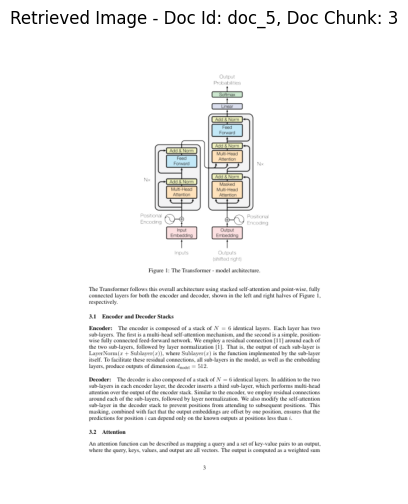

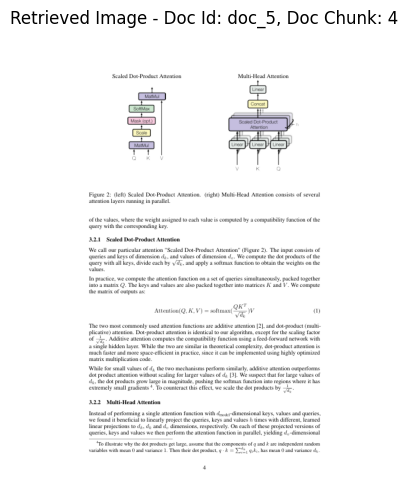

In [37]:
query_text = {
    "text": "What is the transformer model's architecture?"
    }
retrieved_chunks = rag.retrieve_context(query_text, modality="text", top_k=4)
show_retrieved_docs(retrieved_chunks)

Perform semantic search using a image query

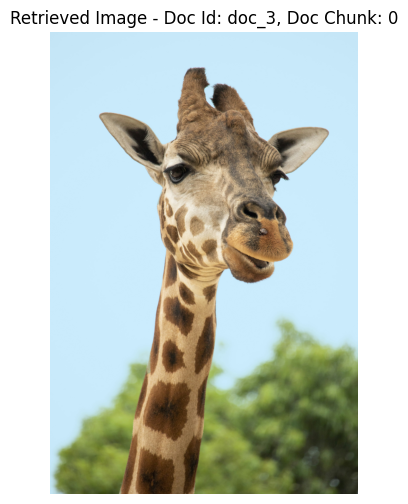

In [38]:
# Use the same image in the knowledge base
query_image = {"image": img_1} # Giraffe
retrieved_chunks = rag.retrieve_context(query_image, modality="image", top_k=1)
show_retrieved_docs(retrieved_chunks)

Perform semantic search using a combined image-text query

Retrieved Text Chunk 1:
The Statue of Liberty, officially named Liberty Enlightening the World, is one of the most iconic symbols of freedom and democracy in the United States. Standing on Liberty Island in New York Harbor, it was a gift from France to the United States, commemorating their friendship and shared ideals of liberty. Dedicated on October 28, 1886, the statue also celebrated the abolition of slavery following the U.S. Civil War.

--------------------------------------------------

Retrieved Text Chunk 2:
The origins of pizza date back to ancient times, with flatbreads being consumed by civilizations such as the Greeks, Romans, and Egyptians. However, modern pizza as we know it today originated in Naples, Italy, during the 18th and 19th centuries. It was initially a simple flatbread topped with basic ingredients like garlic and olive oil, primarily eaten by the working class.

--------------------------------------------------



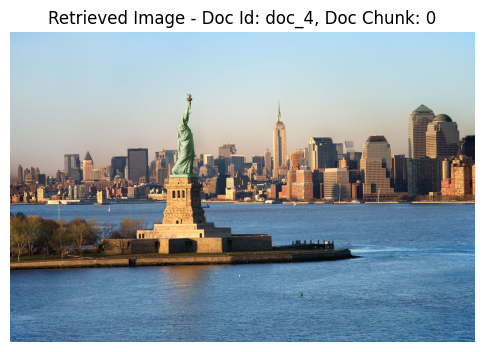

[{'type': 'text', 'id': 'doc_2', 'chunk_id': 0, 'content': 'The Statue of Liberty, officially named Liberty Enlightening the World, is one of the most iconic symbols of freedom and democracy in the United States. Standing on Liberty Island in New York Harbor, it was a gift from France to the United States, commemorating their friendship and shared ideals of liberty. Dedicated on October 28, 1886, the statue also celebrated the abolition of slavery following the U.S. Civil War.'}, {'type': 'text', 'id': 'doc_1', 'chunk_id': 0, 'content': 'The origins of pizza date back to ancient times, with flatbreads being consumed by civilizations such as the Greeks, Romans, and Egyptians. However, modern pizza as we know it today originated in Naples, Italy, during the 18th and 19th centuries. It was initially a simple flatbread topped with basic ingredients like garlic and olive oil, primarily eaten by the working class.'}, {'type': 'image', 'id': 'doc_4', 'chunk_id': 0, 'content': <PIL.Image.Image

In [39]:
# Use the same image in the knowledge base
query_combined = {
    "text": "Where is this image taken from?",
    "image": img_2 # Statue of liberty
}
retrieved_chunks = rag.retrieve_context(query_combined, modality="image-text", top_k=3)
show_retrieved_docs(retrieved_chunks)
print(retrieved_chunks)

### Test the final response

In [40]:
query= {
    "text": "What is in this image?",
    "image": img_1 # giraffe
}

response = rag.generate_response(query, retrieved_chunks)
print("Response:", response)

Response: User:








Answer using the provided multimodal context.

Context:
Text: The Statue of Liberty, officially named Liberty Enlightening the World, is one of the most iconic symbols of freedom and democracy in the United States. Standing on Liberty Island in New York Harbor, it was a gift from France to the United States, commemorating their friendship and shared ideals of liberty. Dedicated on October 28, 1886, the statue also celebrated the abolition of slavery following the U.S. Civil War.
Text: The origins of pizza date back to ancient times, with flatbreads being consumed by civilizations such as the Greeks, Romans, and Egyptians. However, modern pizza as we know it today originated in Naples, Italy, during the 18th and 19th centuries. It was initially a simple flatbread topped with basic ingredients like garlic and olive oil, primarily eaten by the working class.


Query: What is in this image?

Answer:
Assistant: In the image, there is a giraffe in the foreground, look

And there you have it, a functional modular Multimodal RAG pipeline at your disposal! 🤗

Feel free to have a look at the following hugging face leaderboards to help decide and see which models have interesting performance.


*   Multimodal embedding models benchmark: https://huggingface.co/spaces/TIGER-Lab/MMEB
*   Open VLM leaderboard: https://huggingface.co/spaces/opencompass/open_vlm_leaderboard